In [1]:
import numpy as np
import pandas as pd
import tracktor as tr
import cv2
import sys
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment
from scipy.spatial.distance import cdist

## Global parameters
This cell (below) enlists user-defined parameters

In [2]:
# colours is a vector of BGR values which are used to identify individuals in the video
# t_id is termite id and is also used for individual identification
# number of elements in colours should be greater than n_inds (THIS IS NECESSARY FOR VISUALISATION ONLY)
# number of elements in t_id should be greater than n_inds (THIS IS NECESSARY TO GET INDIVIDUAL-SPECIFIC DATA)
n_inds = 8
t_id = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
colours = [(0,0,255),(0,255,255),(255,0,255),(255,255,255),(255,255,0),(255,0,0),(0,255,0),(0,0,0)]

# this is the block_size and offset used for adaptive thresholding (block_size should always be odd)
# these values are critical for tracking performance
block_size = 51
offset = 20

# the scaling parameter can be used to speed up tracking if video resolution is too high (use value 0-1)
scaling = 1.0

# minimum area and maximum area occupied by the animal in number of pixels
# this parameter is used to get rid of other objects in view that might be hard to threshold out but are differently sized
min_area = 500
max_area = 10000

# mot determines whether the tracker is being used in noisy conditions to track a single object or for multi-object
# using this will enable k-means clustering to force n_inds number of animals
mot = True

# in this example, we use a circular mask to ignore area outside the petri-dish
# mask_offset represents offset of circle from centre of the frame
mask_offset_x = -18
mask_offset_y = -5

# name of source video and paths
video = 'termite_video'
input_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/videos/' + video + '.mp4'
output_vidpath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '.mp4'
output_filepath = '/mnt/ssd1/Documents/Vivek/tracktor/output/' + video + '.csv'
codec = 'DIVX' # try other codecs if the default doesn't work ('DIVX', 'avc1', 'XVID') note: this list is non-exhaustive

The cell below runs the tracking code

In [3]:
## Open video
cap = cv2.VideoCapture(input_vidpath)
if cap.isOpened() == False:
    sys.exit('Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file')

## Video writer class to output video with contour and centroid of tracked object(s)
# make sure the frame size matches size of array 'final'
fourcc = cv2.VideoWriter_fourcc(*codec)
output_framesize = (int(cap.read()[1].shape[1]*scaling),int(cap.read()[1].shape[0]*scaling))
out = cv2.VideoWriter(filename = output_vidpath, fourcc = fourcc, fps = 60.0, frameSize = output_framesize, isColor = True)

## Individual location(s) measured in the last and current step
meas_last = list(np.zeros((n_inds,2)))
meas_now = list(np.zeros((n_inds,2)))

df = []
last = 0

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    this = cap.get(1)
    if ret == True:
        # Preprocess the image for background subtraction
        frame = cv2.resize(frame, None, fx = scaling, fy = scaling, interpolation = cv2.INTER_LINEAR)
        
        # Apply mask to ignore area outside the petri dish
        mask = np.zeros((frame.shape[0], frame.shape[1]))
        cv2.circle(mask, (mask.shape[1]//2 + mask_offset_x, mask.shape[0]//2 + mask_offset_y), 520, 255, -1)
        frame[mask == 0] = 0
        
        thresh = tr.colour_to_thresh(frame, block_size, offset)
        # Custom background subtraction
        bg = thresh.copy()
        cv2.circle(bg, (bg.shape[1]//2 + mask_offset_x, bg.shape[0]//2 + mask_offset_y), 520, 0, -1)
        bgsub = thresh - bg
        
        final, contours, meas_last, meas_now = tr.detect_and_draw_contours(frame, thresh, meas_last, meas_now, min_area, max_area)
        if len(meas_now) != n_inds:
            contours, meas_now = tr.apply_k_means(contours, n_inds, meas_now)
        
        row_ind, col_ind = tr.hungarian_algorithm(meas_last, meas_now)
        final, meas_now, df = tr.reorder_and_draw(final, colours, n_inds, col_ind, meas_now, df, mot, this)
        
        # Create output dataframe
        for i in range(n_inds):
            df.append([this, meas_now[i][0], meas_now[i][1], t_id[i]])
        
        # Display the resulting frame
        out.write(final)
        cv2.imshow('frame', final)
        if cv2.waitKey(1) == 27:
            break
            
    if last == this:
        break
    
    last = this

## Write positions to file
df = pd.DataFrame(np.matrix(df), columns = ['frame','pos_x','pos_y', 'id'])
df.to_csv(output_filepath, sep=',')

## When everything done, release the capture
cap.release()
out.release()
cv2.destroyAllWindows()
cv2.waitKey(1)

SystemExit: Video file cannot be read! Please check input_vidpath to ensure it is correctly pointing to the video file

/usr/local/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2971: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


## Summary statistics
The cells below provide functions to perform basic summary statistics - in this case, group polarisation and rotation around group centroid and rotation around centre of the arena. Polarisation measures how aligned individuals in a group are whereas rotation is a measure of the group being in a milling state aka. rotating. Checkout Tunstrom et al. 2013 PLoS Computational Biology for a more detailed description.

In [3]:
df = pd.read_csv(output_filepath)
df.head()

,Unnamed: 0,frame,pos_x,pos_y,id
0,0,3.0,627.810095,197.176362,A
1,1,3.0,1054.999507,424.451290,B
2,2,3.0,506.976989,706.005914,C
3,3,3.0,1273.857786,731.546359,D
4,4,3.0,1378.764774,737.093630,E


In [5]:
df = df.drop(columns=['Unnamed: 0'])
df['dir_x'] = df['pos_x'] - df['pos_x'].shift(n_inds)
df['dir_y'] = df['pos_y'] - df['pos_y'].shift(n_inds)
df['speed'] = np.sqrt(df['dir_x']**2 + df['dir_y']**2)
df['dir_x'] /= df['speed']
df['dir_y'] /= df['speed']

# drop any inf in data
df = df.replace([np.inf, -np.inf], np.nan).dropna(axis=0, how="any")

df.head()

,frame,pos_x,pos_y,id,dir_x,dir_y,speed
8,4.0,627.738315,197.156365,A,-0.963318,-0.268362,0.074514
9,4.0,1054.989501,424.456201,B,-0.897696,0.440615,0.011146
10,4.0,507.090618,706.186679,C,0.532187,0.846627,0.213513
11,4.0,1271.138879,744.371058,D,-0.207396,0.978257,13.109743
12,4.0,1378.624021,738.352216,E,-0.111141,0.993805,1.266432


In [6]:
for idx, ID in enumerate(np.unique(df['id'])):
    df['id'][df['id'] == ID] = idx

/home/user/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


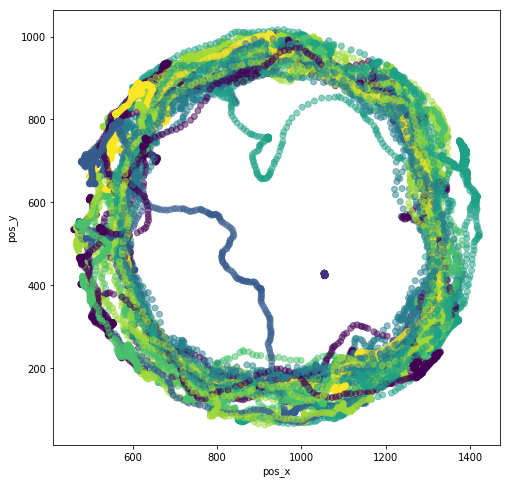

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,8))
plt.scatter(df['pos_x'], df['pos_y'], c=df['id'], alpha=0.5)
plt.xlabel('pos_x')
plt.ylabel('pos_y')
plt.show()

In [11]:
df_ord = df.groupby(['frame']).mean()
df_ord = df_ord.reset_index()

df_ord = df_ord.rename(index=str, columns={'pos_x':'centroid_x', 'pos_y':'centroid_y', 'dir_x':'gdir_x', 'dir_y':'gdir_y', 'speed':'gspeed'})

In [12]:
df = pd.merge(df, df_ord, how='left')

In [ ]:
tmpx = (df['pos_x'] - df['centroid_x'])
tmpy = (df['pos_y'] - df['centroid_y'])
df['centroid_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['centroid_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

tmpx = (df['pos_x'] - mask.shape[1]//2 + mask_offset_x)
tmpy = (df['pos_x'] - mask.shape[0]//2 + mask_offset_y)
df['arena_centre_disp_x'] = tmpx / np.linalg.norm((tmpx, tmpy), axis=0)
df['arena_centre_disp_y'] = tmpy / np.linalg.norm((tmpx, tmpy), axis=0)

In [9]:
centroid_disp = [df['centroid_disp_x'], df['centroid_disp_y']]
direction = [df['dir_x'], df['dir_y']]

arena_disp = [df['arena_centre_disp_x'], df['arena_centre_disp_y']]

In [10]:
df['rotation'] = np.cross(np.array(centroid_disp).T, np.array(direction).T)
df['arena_rotation'] = np.cross(np.array(arena_disp).T, np.array(direction).T)

In [11]:
df_ord = df.groupby(['frame']).agg(['sum', 'count'])
df_ord = df_ord.reset_index()

In [12]:
df_ord['polarisation'] = np.sqrt(df_ord['dir_x']['sum']**2 + df_ord['dir_y']['sum']**2) / df_ord['dir_x']['count']
df_ord['rotation'] = df_ord['rotation']['sum'].divide(df_ord['rotation']['count'])
df_ord['arena_rotation'] = df_ord['arena_rotation']['sum'].divide(df_ord['arena_rotation']['count'])

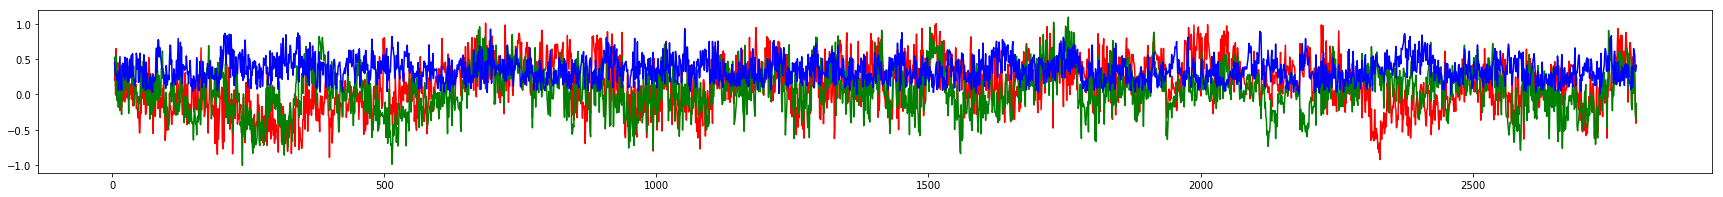

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(30,3))
plt.plot(df_ord['frame'], df_ord['rotation']['sum'], 'r', df_ord['frame'], df_ord['arena_rotation']['sum'], 'g', df_ord['frame'], df_ord['polarisation'], 'b')
plt.show()

/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


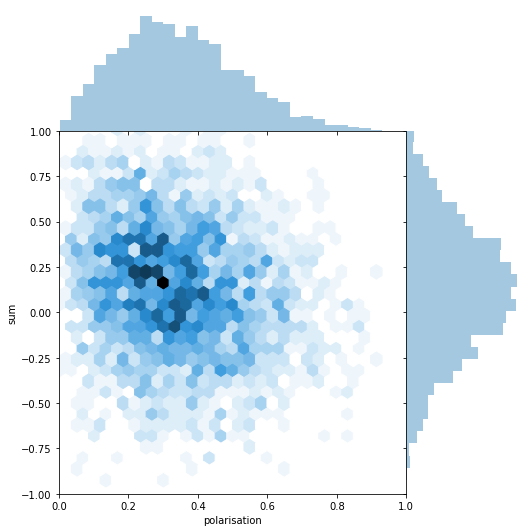

In [16]:
import seaborn as sns

sns.jointplot(df_ord['polarisation'], df_ord['rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plt.show()

/home/user/.local/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


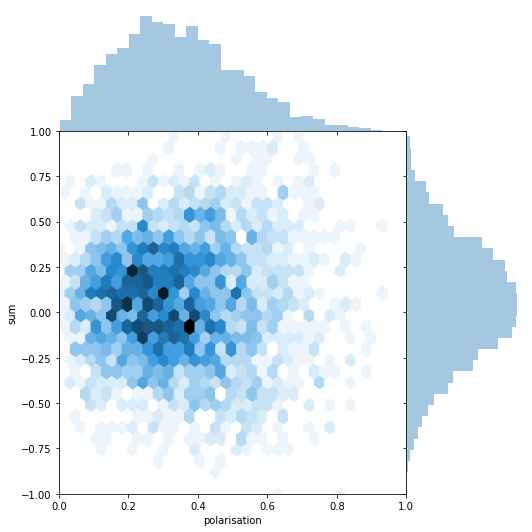

In [17]:
sns.jointplot(df_ord['polarisation'], df_ord['arena_rotation']['sum'], xlim=[0,1], ylim=[-1,1], kind="hex", space=0, size = 7.5, stat_func=None, ratio=3)
plt.show()

In [18]:
print(np.median(df_ord['polarisation']), np.median(np.abs(df_ord['rotation']['sum'])), np.median(np.abs(df_ord['arena_rotation']['sum'])))

0.32835415043948535 0.254349175936953 0.22370895339943453
